### Install dependencies

In [ ]:
!pip install transformers

     |████████████████████████████████| 1.8MB 17.0MB/s 
     |████████████████████████████████| 2.9MB 54.0MB/s 
     |████████████████████████████████| 890kB 53.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=4f8818ffbafc147c9c7c05ee58e4ca058840a8227db7821c8385ed350b6a30fa
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Setup BERT/RoBERTa using Hugging Face Module

In [ ]:
from numpy.random import seed
from tensorflow.random import set_seed
seed(1)
set_seed(2)

In [ ]:
import os
import shutil
data_path = os.path.join("drive","My Drive","toxic_span_identification")

In [ ]:
from transformers import RobertaTokenizerFast, TFRobertaModel
tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")

### Load data

In [ ]:
import pandas as pd
import numpy as np
from ast import literal_eval

In [ ]:
train_data = pd.read_csv(os.path.join(data_path, "datasets", "tsd_train.csv"))
test_data = pd.read_csv(os.path.join(data_path, "datasets", "tsd_test.csv"))

In [ ]:
train_data["spans"] = train_data["spans"].apply(literal_eval)
test_data["spans"] = test_data["spans"].apply(literal_eval)

In [ ]:
print(train_data.head())
print(train_data.shape)
print(test_data.head())
print(test_data.shape)

                                               spans                                               text
0  [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,...  Another violent and aggressive immigrant killi...
1                       [33, 34, 35, 36, 37, 38, 39]  I am 56 years old, I am not your fucking junio...
2                                       [0, 1, 2, 3]                  Damn, a whole family. Sad indeed.
3          [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]  What a knucklehead. How can anyone not know th...
4                       [32, 33, 34, 35, 36, 37, 38]  "who do you think should do the killing?"\n\nA...
(7939, 2)
                                               spans                                               text
0  [84, 85, 86, 87, 88, 89, 90, 91, 133, 134, 135...  That's right. They are not normal. And I am st...
1                           [81, 82, 83, 84, 85, 86]  "Watch people die from taking away their healt...
2                                                 []  

### Preprocess input

In [ ]:
import re
import random
import numpy as np
import spacy
nlp = spacy.load("en_core_web_sm")

In [ ]:
def sentence_tokenize(data):
  base_offset = []
  sentences = []
  sentence_spans = []
  sent_start = []
  for i in range(data.shape[0]):
    text = data['text'][i]
    spans = data['spans'][i]
    left_ptr = 0
    right_ptr = 0
    started = False
    doc = nlp(text)
    for sent in doc.sents:
      start = doc[sent.start].idx
      end = doc[sent.end-1].idx + len(doc[sent.end-1])
      if end-start<=1 :
        continue
      sentences.append(text[start:end])
      base_offset.append(start)
      if started==False:
        started = True
        sent_start.append(True)
      else:
        sent_start.append(False)
      while left_ptr < len(spans) and spans[left_ptr] < start:
        left_ptr+=1
      right_ptr = left_ptr
      cur_spans = []
      while right_ptr < len(spans) and spans[right_ptr] < end:
        cur_spans.append(spans[right_ptr])
        right_ptr+=1
      sentence_spans.append(cur_spans)
      left_ptr = right_ptr
    if started==False:
      sentences.append(text)
      base_offset.append(0)
      sentence_spans.append(spans)
      sent_start.append(True)
  data_processed = pd.DataFrame(data={"text":sentences,"spans":sentence_spans,"base_offset":base_offset,"sent_start":sent_start})
  return data_processed

In [ ]:
def preprocessing(data, max_length):
  data_processed = sentence_tokenize(data)
  tokens = tokenizer(list(data_processed.text), max_length=max_length, padding="max_length",
                         truncation=True, return_offsets_mapping=True, return_special_tokens_mask=True,
                         return_token_type_ids = True)
  input_dict = {"input_ids" : np.array(tokens.input_ids),
                "token_type_ids" : np.array(tokens.token_type_ids), 
                "attention_mask" : np.array(tokens.attention_mask) }
  return data_processed, tokens, input_dict

In [ ]:
max_length = 60

In [ ]:
train_data_processed, train_tokens, train_input = preprocessing(train_data, max_length)
test_data_processed, test_tokens, test_input = preprocessing(test_data, max_length)

In [ ]:
print(train_data_processed[:10])
print(train_data_processed.shape)

                                                text  ... sent_start
0  Another violent and aggressive immigrant killi...  ...       True
1                                            Sarcasm  ...      False
2  I am 56 years old, I am not your fucking junio...  ...       True
3                What you are saying makes no sense.  ...      False
4          I don't know what you are basing this on.  ...      False
5  The cheap black market crap is still coming up...  ...      False
6  The I5 corridor is still just as busy, and the...  ...      False
7  Nothing has really changed except that the leg...  ...      False
8  And the legal market is controlled by corporat...  ...      False
9  The Federal government "war on drugs" really h...  ...      False

[10 rows x 4 columns]
(26247, 4)


In [ ]:
print(test_data_processed[:10])
print(test_data_processed.shape)

                                                text  ... sent_start
0                                      That's right.  ...       True
1                               They are not normal.  ...      False
2  And I am starting from the premise that they a...  ...      False
3  Proceed wth the typical racist, bigot, sexist ...  ...      False
4                                            Thanks!  ...      False
5  "Watch people die from taking away their healt...  ...       True
6            Winner of stupid post of the day award!  ...      False
7  tens years ago i contacted the PDR and suggest...  ...       True
8  alaska rejected them without even consideratio...  ...      False
9  the transcanada-exxon rip off that we are stil...  ...      False

[10 rows x 4 columns]
(6175, 4)


In [ ]:
# check offsets for a random sample
idx = random.randint(0, train_data_processed.shape[0])
print(idx)
print(train_data_processed.text[idx])
i = 0
for s,e in train_tokens.offset_mapping[idx]:
  if s!=0 or e!=0:
    print(train_data_processed.text[idx][s:e]," ", tokenizer.convert_ids_to_tokens(train_tokens.input_ids[idx][i]))
  i+=1

13378
You can't fix stupid.
You   You
can   Ġcan
't   't
fix   Ġfix
stupid   Ġstupid
.   .


### Create IO,BIO output

In [ ]:
import string

In [ ]:
# prepare the output toxic/non toxic labels
def generate_output(data, tokens):  
  output = np.zeros((data.shape[0],max_length))
  for i in range(data.shape[0]):
    isToxic = np.zeros(len(data.text[i]))
    for idx in data.spans[i]:
      isToxic[idx-data.base_offset[i]]=1
    for j in range(max_length):
      if tokens.special_tokens_mask[i][j]:
        continue
      start = tokens.offset_mapping[i][j][0]
      end = tokens.offset_mapping[i][j][1]
      cnt = 0
      for pos in range(start,end):
        if isToxic[pos]:
          cnt+=1
      if cnt>=(end-start+1)//2:
        output[i][j]=1
  return output

In [ ]:
train_output = generate_output(train_data_processed, train_tokens)
train_shape = train_output.shape
train_samples = train_output.shape[0] * train_output.shape[1]
train_output_1d = train_output.reshape((train_samples,))
train_toxic_samples = np.sum(train_output)
print("Training data stats")
print("Shape of data:",train_output.shape)
print("Number of toxic samples:",train_toxic_samples)
print("Fraction of toxic samples: ",train_toxic_samples/train_samples)

Training data stats
Shape of data: (26247, 60)
Number of toxic samples: 41671.0
Fraction of toxic samples:  0.026460801869419997


In [ ]:
test_output = generate_output(test_data_processed,test_tokens)
test_shape = test_output.shape
test_samples = test_output.shape[0] * test_output.shape[1]
test_output_1d = test_output.reshape((test_samples,))
test_toxic_samples = np.sum(test_output)
print("Test data stats")
print("Shape of data:",test_output.shape)
print("Number of toxic samples:",test_toxic_samples)
print("Fraction of toxic samples:",test_toxic_samples/test_samples)

Test data stats
Shape of data: (6175, 60)
Number of toxic samples: 5816.0
Fraction of toxic samples: 0.01569770580296896


In [ ]:
sample_weight = 1 - np.array(train_tokens.special_tokens_mask)

In [ ]:
sample_weight_1d = sample_weight.reshape((train_samples,))
valid_tokens = np.sum(sample_weight)
print("No. of non padding ie valid tokens:",valid_tokens)
print("Fraction of valid tokens:",valid_tokens/train_samples)
print("Toxic samples as fraction of valid tokens:",np.sum(sample_weight * train_output)/valid_tokens)

No. of non padding ie valid tokens: 377174
Fraction of valid tokens: 0.2395029273186777
Toxic samples as fraction of valid tokens: 0.11048216473033666


In [ ]:
toxic_words = []
for i in range(train_shape[0]):
  for j in range(max_length):
    if train_output[i,j]==1 and sample_weight[i,j]==1:
      toxic_words.append(tokenizer.convert_ids_to_tokens(train_tokens.input_ids[i][j]))
toxic_words_freq = pd.Series(toxic_words).value_counts()
toxic_words_freq[:25]

Ġ             11088
Ġstupid        1094
Ġidiot          605
Ġthe            509
,               432
Ġidiots         373
Ġa              372
Ġand            325
Ġmor            291
Ġof             285
.               282
Ġstupidity      259
Ġis             258
Ġto             256
Ġignorant       255
Ġdumb           210
on              200
Ġfool           176
Ġin             172
Ġyou            170
Ġare            166
-               154
Ġcrap           144
Ġthat           137
Ġpathetic       137
dtype: int64

### Post processing function definitions

In [ ]:
import string

In [ ]:
def get_threshold(train_pred):
  train_pred_1d = train_pred.reshape((train_samples,))
  sample_weight_mask = sample_weight_1d.astype("bool")
  train_output_mask = train_output_1d[sample_weight_mask]
  train_pred_mask = train_pred_1d[sample_weight_mask]
  fpr, tpr, _ = roc_curve(train_output_mask , train_pred_mask)
  precisions, recalls , thresholds = precision_recall_curve(train_output_mask, train_pred_mask)
  f1_scores = []
  for prec,rec in zip(precisions,recalls):
    if prec+rec >= 1e-2 :
      cur_f1 = (2*prec*rec)/(prec+rec);
      f1_scores.append(cur_f1)
    else :
      f1_scores.append(0)
  idx = np.argmax(f1_scores)
  return thresholds[idx], f1_scores[idx]

In [ ]:
def classify_bio_output(prediction):
  num_samples = prediction.shape[0]*prediction.shape[1]
  res = np.zeros((prediction.shape[0],prediction.shape[1]))
  for i in range(prediction.shape[0]):
    for j in range(prediction.shape[1]):
      if prediction[i,j] != 0:
        res[i,j] = 1
  return res

In [ ]:
def classify_by_threshold(prediction, thresh):
  res = np.zeros(prediction.shape)
  for i in range(prediction.shape[0]):
    for j in range(prediction.shape[1]):
      if prediction[i,j]>=thresh:
        res[i,j]=1
  return res

In [ ]:
def convert_output_to_ranges(data_processed, tokens, prediction_label):
  """
  Arguments
  data_processed: dataframe where the result is to be stored
  tokens : BatchEncoding for text column in the dataframe

  Return type: Pandas Series of size = #samples
  For each sentence, a list of compressed toxic spans is returned
  If the token is labelled toxic, then its offset ranges obtained from tokens is appended to the list
  """
  spans_column = []
  num_samples = data_processed.shape[0];
  for i in range(num_samples):
    comp_ranges = []
    cur = {}
    for j in range(max_length):
      if prediction_label[i][j]==0 or tokens.special_tokens_mask[i][j]==1:
        continue
      cur['start'] = tokens.offset_mapping[i][j][0]
      cur['end'] = tokens.offset_mapping[i][j][1]
      comp_ranges.append([cur['start'],cur['end']])
    spans_column.append(comp_ranges)
  return pd.Series(spans_column)

In [ ]:
def add_offset(row):
  """
  Argument: a row of a dataframe with columns - predicted_spans , base_offset
  Returns the predicted spans after adding base offset to both the lower and upper endpoints
  for all all ranges
  """
  updated_spans = []
  for i in range(len(row.predicted_ranges)):
    updated_spans.append([row.predicted_ranges[i][0]+row.base_offset, 
                          row.predicted_ranges[i][1]+row.base_offset])
  return updated_spans

In [ ]:
def collect_ranges(data, data_processed):
  """
  Returns a pandas series after collecting spans
  from data_processed for the given texts in data
  """
  j=0
  new_col = []
  for i in range(data.shape[0]):
    all_spans = data_processed['adjusted_ranges'][j]
    j+=1
    while j<data_processed.shape[0] and data_processed.sent_start[j]==False:
      all_spans = all_spans + data_processed['adjusted_ranges'][j]
      j+=1
    new_col.append(all_spans)
  return pd.Series(new_col)

In [ ]:
def merge_ranges(row):
  """
  Returns a new list after merging very close ranges
  """
  old_list = row.collected_ranges
  text = row.text
  prev = {}
  prev['start'] = -1
  prev['end'] = -1
  cur = {}
  new_list = []
  for i in range(len(old_list)):
    cur['start'] = old_list[i][0]
    cur['end'] = old_list[i][1]
    if prev['start'] != -1:
      cntAlpha = 0
      for j in range(prev['end'],cur['start']):
        if text[j].isalpha():
          cntAlpha+=1
      if cntAlpha==0 and (cur['start']-prev['end'])<=5:
        new_list.pop()
        cur['start'] = prev['start']
    new_list.append([cur['start'],cur['end']])
    prev['start'] = cur['start']
    prev['end'] = cur['end']
  return new_list

In [ ]:
def expand_ranges(old_list):
  """
  Returns a new list after expanding ranges
  """
  new_list = []
  for item in old_list:
    new_list = new_list + (list(range(item[0],item[1])))
  return new_list

In [ ]:
def f1(predictions, gold):
    """
    F1 (a.k.a. DICE) operating on two lists of offsets (e.g., character).
    >>> assert f1([0, 1, 4, 5], [0, 1, 6]) == 0.5714285714285714
    :param predictions: a list of predicted offsets
    :param gold: a list of offsets serving as the ground truth
    :return: a score between 0 and 1
    """
    if len(gold) == 0:
        return 1 if len(predictions)==0 else 0
    nom = 2*len(set(predictions).intersection(set(gold)))
    denom = len(set(predictions))+len(set(gold))
    return nom/denom

In [ ]:
def precision(predictions, gold):
    """
    F1 (a.k.a. DICE) operating on two lists of offsets (e.g., character).
    >>> assert f1([0, 1, 4, 5], [0, 1, 6]) == 0.5714285714285714
    :param predictions: a list of predicted offsets
    :param gold: a list of offsets serving as the ground truth
    :return: a score between 0 and 1
    """
    if len(predictions) == 0:
        return 1 if len(gold)==0 else 0
    nom = len(set(predictions).intersection(set(gold)))
    denom = len(set(predictions))
    return nom/denom

In [ ]:
def recall(predictions, gold):
    """
    F1 (a.k.a. DICE) operating on two lists of offsets (e.g., character).
    >>> assert f1([0, 1, 4, 5], [0, 1, 6]) == 0.5714285714285714
    :param predictions: a list of predicted offsets
    :param gold: a list of offsets serving as the ground truth
    :return: a score between 0 and 1
    """
    if len(gold) == 0:
        return 1 if len(predictions)==0 else 0
    nom = len(set(predictions).intersection(set(gold)))
    denom = len(set(gold))
    return nom/denom

In [ ]:
def spans2ranges(span):
  ranges = []
  prev = -1
  range = {'start':-1,'end':-1}
  for pos in span :
    if prev==-1 or pos>prev+1:
      if prev != -1:
        ranges.append([range['start'],range['end']+1])
      range['start'] = pos
    range['end'] = pos
    prev = pos
  if prev !=-1:
    ranges.append([range['start'],range['end']+1])
  return ranges

In [ ]:
def post_process(data, data_processed, tokens, prediction, thresh):
  if thresh is None :
    prediction_label = classify_bio_output(prediction);
  else :
    prediction_label = classify_by_threshold(prediction,thresh);
  data_processed['predicted_ranges'] = convert_output_to_ranges(data_processed, tokens, prediction_label)
  data_processed['adjusted_ranges'] = data_processed.apply(add_offset,axis=1)
  data['collected_ranges'] = collect_ranges(data, data_processed)
  data['predicted_ranges'] = data.apply(merge_ranges,axis=1) 
  data['predicted_spans'] = data['predicted_ranges'].apply(expand_ranges) 
  data['actual_ranges'] = data['spans'].apply(spans2ranges)
  f1_list = []
  precision_list = []
  recall_list = []
  for i in range(data.shape[0]):
    f1_list.append(f1(data.predicted_spans[i],data.spans[i]))
    precision_list.append(precision(data.predicted_spans[i],data.spans[i]))
    recall_list.append(recall(data.predicted_spans[i],data.spans[i]))
  mean_f1 = np.mean(np.array(f1_list))
  mean_precision = np.mean(np.array(precision_list))
  mean_recall = np.mean(np.array(recall_list))
  return mean_f1, mean_precision, mean_recall

### Set the model hyper parameters

In [ ]:
def get_pretrained_model_path(pre_training_epoch):
  return os.path.join(data_path, "pre_training")

def get_weights_path_folder(params):
  return os.path.join(data_path, "Roberta-preTraining")

def get_weights_path(params, cur_epoch):
  return os.path.join( get_weights_path_folder(params),"{:02d}_epochs.h5".format(cur_epoch) )

In [ ]:
params = {
  "model_name" : "Dense512",
  "training" : True,
  "learning_rate" : 1e-5,
  "pre_training_epoch" : 2,
  "initial_epoch" : 0,
  "epochs" : 5,
  "silver" : False,
}

### Models and metrics definition

In [ ]:
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense,Flatten, Dropout
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
# model_name "Dense512"
def get_dense512(pre_training_epoch, training):
  input_ids = Input(shape=(max_length),name="input_ids",dtype="int32")
  token_type_ids = Input(shape=(max_length),name="token_type_ids")
  attention_mask = Input(shape=(max_length),name="attention_mask")
  if pre_training_epoch == 0:
    encoder = TFRobertaModel.from_pretrained("roberta-base")
  else:
    encoder = TFRobertaModel.from_pretrained(get_pretrained_model_path(pre_training_epoch), from_pt = True)
  embeddings = encoder({"input_ids":input_ids,"token_type_ids":token_type_ids,"attention_mask":attention_mask}, training=training)[0]
  dropout_layer0 = Dropout(rate = 0.1)(embeddings, training=training)
  dense_layer0 = Dense(512, activation="relu")(dropout_layer0)
  dropout_layer1 = Dropout(rate = 0.1)(dense_layer0, training=training)
  dense_layer1 = Dense(128, activation="relu")(dropout_layer1)
  dropout_layer2 = Dropout(rate = 0.1)(dense_layer1, training=training)
  dense_layer2 = Dense(1,activation='sigmoid')(dropout_layer2)
  outputs = Flatten()(dense_layer2)
  return Model(inputs = [input_ids, token_type_ids, attention_mask ] ,outputs = outputs)

In [ ]:
def get_model(params):
  model_name = params['model_name']
  pre_training_epoch = params['pre_training_epoch']
  training = params['training']
  if model_name == "Dense512":
    return get_dense512(pre_training_epoch, training)

### Loss function

In [ ]:
import tensorflow.keras.backend as K

In [ ]:
def binary_loss(y_true, y_pred):
  loss = -1 * y_true * K.log( K.clip(y_pred + K.epsilon(), 0, 1.0) )
  loss += -1 * (1-y_true) * K.log( K.clip(1-y_pred+K.epsilon(), 0, 1.0) )
  return loss

### Create and train model as per above chosen hyper parameters

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.decoder.bias', 'roberta.embeddings.position_ids', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream 

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <cyfunction Socket.send at 0x7feac2cb32a0> is not a module, class, method, function, traceback, frame, or code object
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <cyfunction Socket.send at 0x7feac2cb32a0> is not a module, class, method, function, traceback, frame, or code object
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
attention_mask (InputLayer)     [(None, 60)]         0                                            
__________________________________________________________________________________________________
input_ids (InputLayer)          [(None, 60)]         0                                            
__________________________________________________________________________________________________
token_type_ids (InputLayer)     [(None, 60)]         0                                            
__________________________________________________________________________________________________
tf_roberta_model (TFRobertaMode TFBaseModelOutputWit 

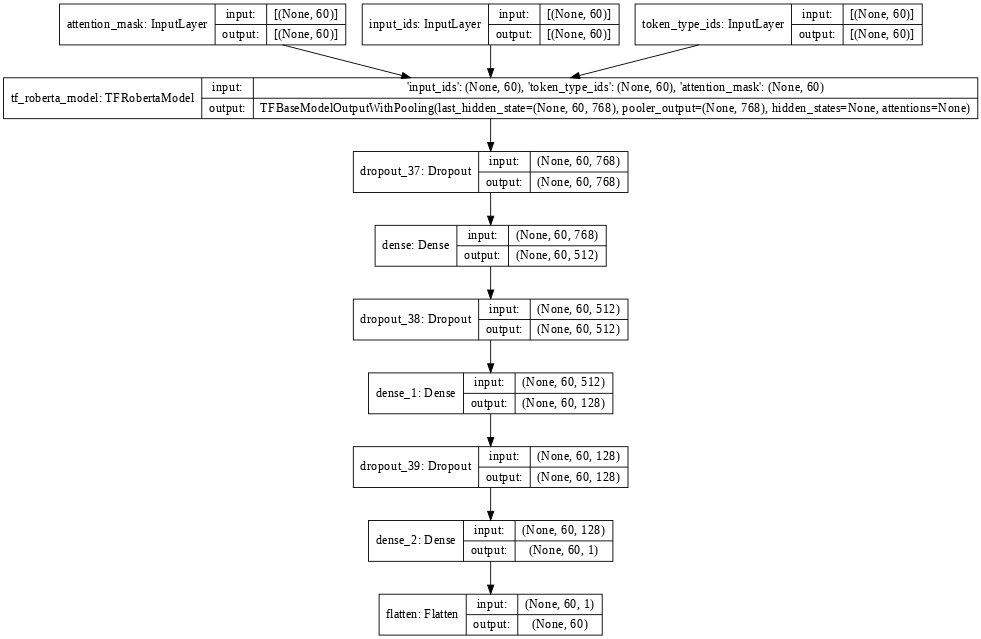

In [ ]:
model = get_model(params)
if params['initial_epoch'] !=0 :
  model.load_weights(get_weights_path(params, params['initial_epoch']))

model.summary()
tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate = params['learning_rate'])
model.compile(optimizer = optimizer,loss = binary_loss)
weights_path = os.path.join(get_weights_path_folder(params), "{epoch:02d}_epochs.h5")
checkpoint = ModelCheckpoint(weights_path, save_weights_only=True)

In [ ]:
# create a folder to save the weights 
dir = get_weights_path_folder(params)
if params['initial_epoch'] == 0:
  if os.path.exists(dir):
      shutil.rmtree(dir)
  os.makedirs(dir)

In [ ]:
hist = model.fit(train_input, train_output, epochs=params['epochs'], initial_epoch = params['initial_epoch'],
                 sample_weight = sample_weight,
                 callbacks = [checkpoint] )

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


Epoch 1/5


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


821/821 [==============================] - 350s 414ms/step - loss: 0.0684
Epoch 2/5
821/821 [==============================] - 342s 417ms/step - loss: 0.0491
Epoch 3/5
821/821 [==============================] - 342s 417ms/step - loss: 0.0428
Epoch 4/5
821/821 [==============================] - 342s 416ms/step - loss: 0.0338
Epoch 5/5
821/821 [==============================] - 343s 417ms/step - loss: 0.0286


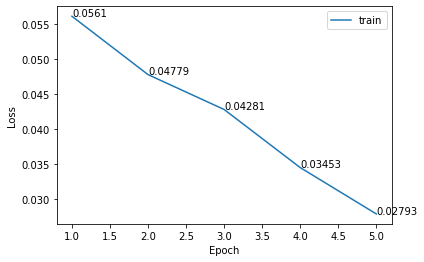

In [ ]:
if params['initial_epoch'] == 0:
  dir = get_weights_path_folder(params)
  epoch_list = range(1,params['epochs']+1)
  plt.plot(epoch_list, hist.history['loss'], label='train')
  for x,y in zip(epoch_list, hist.history['loss']):
    label = "{:.4}".format(y)
    plt.annotate(label, (x,y))
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend()
  plt.savefig(os.path.join(dir, "loss"))

### Generate F1 report across epochs

In [ ]:
def calc_results(params, start_epoch, end_epoch):
  params_copy = params.copy()
  params_copy['training'] = False
  model = get_model(params_copy)
  train_mean_stats = []
  test_mean_stats = []
  for cur_epoch in range(start_epoch, end_epoch+1):
    print("Epoch",cur_epoch)
    model.load_weights(get_weights_path(params, cur_epoch))
    train_pred = model.predict(train_input, verbose = 1)
    thresh, token_f1 = get_threshold(train_pred)
    test_pred = model.predict(test_input, verbose = 1)
    stats = post_process(train_data, train_data_processed, train_tokens, train_pred, thresh)
    train_mean_stats.append(stats)
    stats = post_process(test_data, test_data_processed, test_tokens, test_pred, thresh)
    test_mean_stats.append(stats)
  return train_mean_stats, test_mean_stats

In [ ]:
def print_results(params, train_mean_f1, test_mean_f1, save_results):
  print("Mean F1")
  print('Train set peak val :',np.max(train_mean_f1, keepdims=True))
  print('Test set peak val :',np.max(test_mean_f1, keepdims=True),'at epoch',1+np.argmax(test_mean_f1))
  print()
  num_epochs = len(train_mean_f1)
  epoch_list = range(1,num_epochs+1)
  plt.plot(epoch_list,train_mean_f1, label = "train")
  plt.plot(epoch_list, test_mean_f1, label = "test")
  for x,y in zip(epoch_list, train_mean_f1):
    label = "{:.4}".format(y)
    plt.annotate(label, (x,y), xytext = (0,7), textcoords = "offset pixels")
  for x,y in zip(epoch_list, test_mean_f1):
    label = "{:.4}".format(y)
    plt.annotate(label, (x,y), xytext = (0,-7), textcoords = "offset pixels")
  plt.legend()
  plt.xlabel("Epoch")
  plt.ylabel("Mean F1 score")
  if save_results:
    dir = get_weights_path_folder(params)
    plt.savefig(os.path.join(dir, "f1_scores"))

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.decoder.bias', 'roberta.embeddings.position_ids', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream 

Epoch 1


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


193/193 [==============================] - 25s 130ms/step
Epoch 2
193/193 [==============================] - 25s 129ms/step
Epoch 3
193/193 [==============================] - 25s 129ms/step
Epoch 4
193/193 [==============================] - 25s 129ms/step
Epoch 5
193/193 [==============================] - 25s 129ms/step
Train dataset stats(f1, precision, recall) across epochs
Epoch 1 (0.6360259296042202, 0.679734481979408, 0.7063474436405859)
Epoch 2 (0.6607167542476107, 0.6916356330776964, 0.7435808443727925)
Epoch 3 (0.6870660543374693, 0.6993930665907028, 0.776306743463652)
Epoch 4 (0.7080034783102817, 0.721666510558867, 0.77668325214864)
Epoch 5 (0.7196119173047654, 0.7446249042120345, 0.7614642656779811)

Test dataset stats(f1, precision, recall) across epochs
Epoch 1 (0.6182808915670769, 0.5840807232144937, 0.740786996721148)
Epoch 2 (0.6119354435171049, 0.5705057336395234, 0.7507875931276082)
Epoch 3 (0.5999548767377508, 0.5594560403462392, 0.7451149821770345)
Epoch 4 (0.6013916

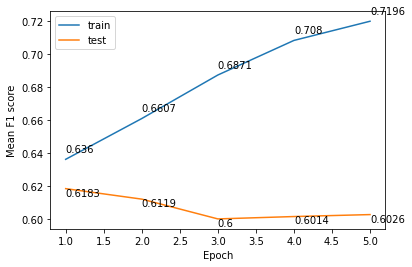

In [ ]:
train_mean_stats, test_mean_stats = calc_results(params, 1, params['epochs'])
print("Train dataset stats(f1, precision, recall) across epochs")
e = 1
for stats in train_mean_stats:
  print("Epoch", e, end=" ")
  print(stats)
  e += 1
print()
print("Test dataset stats(f1, precision, recall) across epochs")
e = 1
for stats in test_mean_stats:
  print("Epoch", e, end=" ")
  print(stats)
  e += 1
print()
train_mean_f1 = [stats[0] for stats in train_mean_stats]
test_mean_f1 = [stats[0] for stats in test_mean_stats]
print_results(params, train_mean_f1, test_mean_f1 , True)